In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
from joblib import Parallel, delayed

path_root = '../../../data'
path_data = '../../../data'
target_name = 'target'
scores_folds = {}

In [12]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return (np.sqrt(np.sum(series_log_return**2)))

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred)/y_true)))

def get_stock_stat(stock_id: int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    # stock features
    df_book = pd.read_parquet(path_root+f'/book_{dataType}.parquet/stock_id={stock_id}')
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1']*df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1']) / (
                            df_book['ask_size1'] + df_book['bid_size1'])
    df_book['wap2'] = (df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size2'] + df_book['bid_size2'])
    df_book['log_return1'] = df_book.groupby(by=['time_id'])['wap1'].apply(log_return).fillna(0)
    df_book['log_return2'] = df_book.groupby(by=['time_id'])['wap2'].apply(log_return).fillna(0)
    
    # Ryotaro Features
    df_book['typical_price'] = (df_book['bid_price1'] + df_book['ask_price1'] + df_book['wap1']) / 3
    features_to_apply_realized_volatility = ['log_return'+str(i) for i in range(1, 3)]
    features_to_apply_realized_volatility += ['typical_price']
    stock_stat = df_book.groupby(by=['stock_id', 'time_id'])[features_to_apply_realized_volatility].agg(realized_volatility).reset_index()
    
    # trade features
    trade_stat = pd.read_parquet(path_root + f'/trade_{dataType}.parquet/stock_id={stock_id}')
    trade_stat = trade_stat.sort_values(by=['time_id', 'seconds_in_bucket']).reset_index(drop=True)
    trade_stat['stock_id'] = stock_id
    cols = key + [col for col in trade_stat.columns if col not in key]
    trade_stat = trade_stat[cols]
    trade_stat['trade_log_return1'] = trade_stat.groupby(by=['time_id'])['price'].apply(log_return).fillna(0)
    trade_stat = trade_stat.groupby(by=['stock_id', 'time_id'])[['trade_log_return1']].agg(realized_volatility).reset_index()
    
    # joining book and trade features
    stock_stat = stock_stat.merge(trade_stat, on=['stock_id', 'time_id'], how='left').fillna(-999)
    return stock_stat

def get_dataSet(stock_ids: list, dataType='train'):
    stock_stat = Parallel(n_jobs=-1)(
        delayed(get_stock_stat)(stock_id, dataType)
        for stock_id in stock_ids
    )
    stock_stat_df = pd.concat(stock_stat, ignore_index=True)
    return stock_stat_df

train = pd.read_csv(path_root + '/train.csv')
train_stock_stat_df = get_dataSet(stock_ids=train['stock_id'][:5].unique(), dataType='train')
train = pd.merge(train, train_stock_stat_df, on=['stock_id', 'time_id'], how='left').fillna(0)

In [19]:
def get_stock_stat(stock_id: int, dataType = 'train'):
    key = ['stock_id', 'time_id', 'seconds_in_bucket']
    
    # stock features
    df_book = pd.read_parquet(path_root+f'/book_{dataType}.parquet/stock_id={stock_id}')
    df_book['stock_id'] = stock_id
    cols = key + [col for col in df_book.columns if col not in key]
    df_book = df_book[cols]
    
    df_book['wap1'] = (df_book['bid_price1']*df_book['ask_size1'] + df_book['ask_price1']*df_book['bid_size1']) / (
                            df_book['ask_size1'] + df_book['bid_size1'])
    df_book['wap2'] = (df_book['bid_price2']*df_book['ask_size2'] + df_book['ask_price2']*df_book['bid_size2']) / (
                            df_book['ask_size2'] + df_book['bid_size2'])
    df_book['log_return1'] = df_book.groupby(by=['time_id'])['wap1'].apply(log_return).fillna(0)
    df_book['log_return2'] = df_book.groupby(by=['time_id'])['wap2'].apply(log_return).fillna(0)
    
    # Ryotaro Features
    df_book['typical_price'] = (df_book['bid_price1'] + df_book['ask_price1'] + df_book['wap1']) / 3
    features_to_apply_realized_volatility = ['log_return'+str(i) for i in range(1, 3)]
    features_to_apply_realized_volatility += ['typical_price', 'stock_id', 'time_id', 'wap1', 'wap2']
    return df_book[features_to_apply_realized_volatility]

stock_df = get_stock_stat(stock_id=0)
df = pd.read_csv(path_root + '/train.csv')
df = pd.merge(df, stock_df, on=['stock_id', 'time_id'], how='left').fillna(0)
df.head()

,stock_id,time_id,target,log_return1,log_return2,typical_price,wap1,wap2
0,0,5,0.004136,0.000000,0.000000,1.001719,1.001434,1.001390
1,0,5,0.004136,0.000014,0.000000,1.001724,1.001448,1.001390
2,0,5,0.004136,0.000000,0.000001,1.001724,1.001448,1.001391
3,0,5,0.004136,-0.000005,0.000000,1.001722,1.001443,1.001391
4,0,5,0.004136,0.000000,0.000000,1.001722,1.001443,1.001391


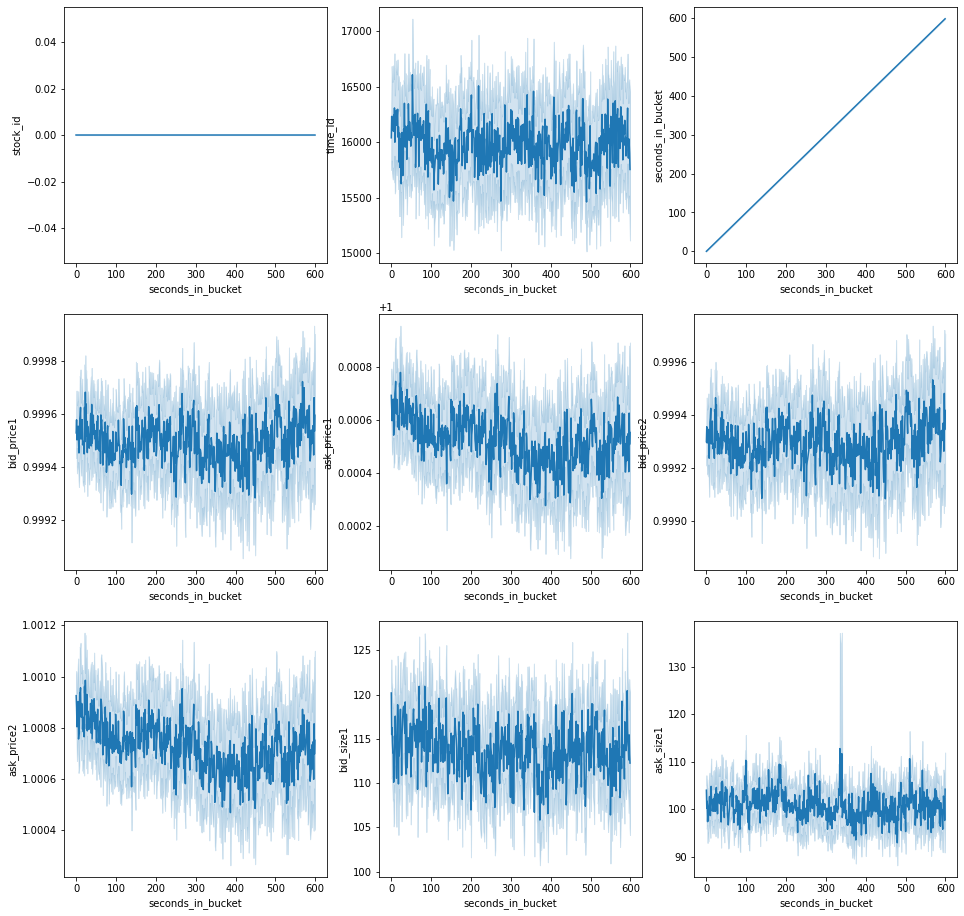

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
cols = ["wap1", "wap1", "typical_price", "bid_price1", ""]